In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt

from Qgps import GPS

%matplotlib ipympl

In [2]:
data_path = "calsource_orientation_20240322.dat"
base_antenna_position = np.array([0, 0, 0])
distance_between_antennas = 1
distance_calsource = distance_between_antennas/2
observation_date = np.array([dt.datetime(2024, 3, 22, 9, 47, 49), dt.datetime(2024, 3, 22, 16, 13, 49, 500000)])

In [3]:
gps = GPS(data_path, base_antenna_position, distance_between_antennas, distance_calsource, observation_date)

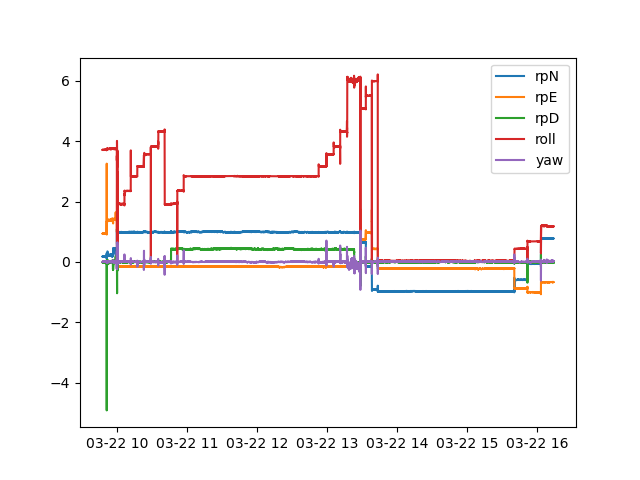

In [4]:
plt.figure()
plt.plot(gps.observation_datetime, gps.rpN, label='rpN')
plt.plot(gps.observation_datetime, gps.rpE, label='rpE')
plt.plot(gps.observation_datetime, gps.rpD, label='rpD')
plt.plot(gps.observation_datetime, gps.roll, label='roll')
plt.plot(gps.observation_datetime, gps.yaw, label='yaw')
plt.legend()

In [5]:
gps.datetime

array([datetime.datetime(2024, 3, 22, 9, 47, 49),
       datetime.datetime(2024, 3, 22, 9, 47, 49, 125000),
       datetime.datetime(2024, 3, 22, 9, 47, 49, 250000), ...,
       datetime.datetime(2024, 3, 22, 16, 13, 49, 250000),
       datetime.datetime(2024, 3, 22, 16, 13, 49, 375000),
       datetime.datetime(2024, 3, 22, 16, 13, 49, 500000)], dtype=object)

In [6]:
idx = gps.get_observation_indices(gps.datetime, np.array([dt.datetime(2024, 3, 22, 10, 2, 00)]))

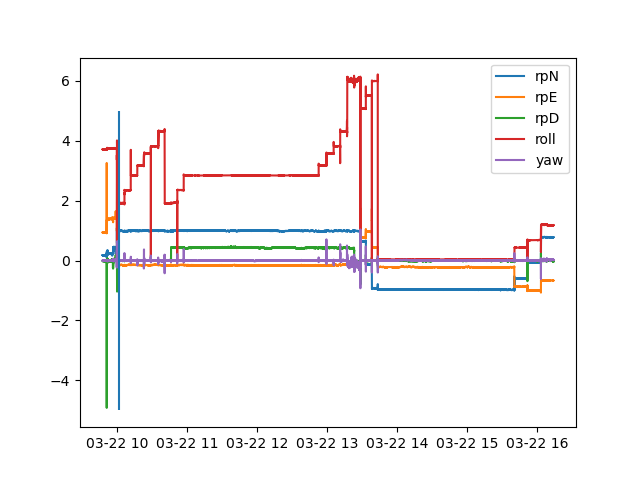

In [7]:
plt.figure()
plt.plot(gps.observation_datetime, gps.rpN, label='rpN')
plt.plot(gps.observation_datetime, gps.rpE, label='rpE')
plt.plot(gps.observation_datetime, gps.rpD, label='rpD')
plt.plot(gps.observation_datetime, gps.roll, label='roll')
plt.plot(gps.observation_datetime, gps.yaw, label='yaw')
plt.vlines(gps.observation_datetime[idx], -5, 5)
plt.legend()

In [8]:
print('calsource', gps.position_calsource_ned[:, idx])
print('antenna 1', gps.position_antenna1_ned[:, idx])
print('antenna 2', gps.position_antenna2_ned[:, idx])
print('orientation', gps.calsource_orientation_angles[:, idx])

calsource [[0.81358675]
 [0.32035333]
 [0.00371487]]
antenna 1 [[0.6398735 ]
 [0.78920665]
 [0.00422974]]
antenna 2 [[ 0.9873]
 [-0.1485]
 [ 0.0032]]
orientation [[ 0.17101667]
 [ 0.        ]
 [20.18147278]]


In [9]:
def plot_angle_arc(ax, origin, v1, v2, angle, num_points=100, radius=0.5, color='orange'):
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)
    
    angles = np.linspace(0, angle * np.pi / 2, num_points)
    
    arc_points = np.outer(np.cos(angles), v1_norm) + np.outer(np.sin(angles), v2_norm)
    arc_points *= radius
    arc_points += origin
    
    print('Angle', angle)
    ax.plot(arc_points[:, 0], arc_points[:, 1], arc_points[:, 2], linewidth=2, color=color, label=f'Angle = {np.degrees(angle):.2f}°')

[ 0.81441447  0.3182432  -0.        ]
Angle 0.002984803934655019
Angle 0.3522331479213475


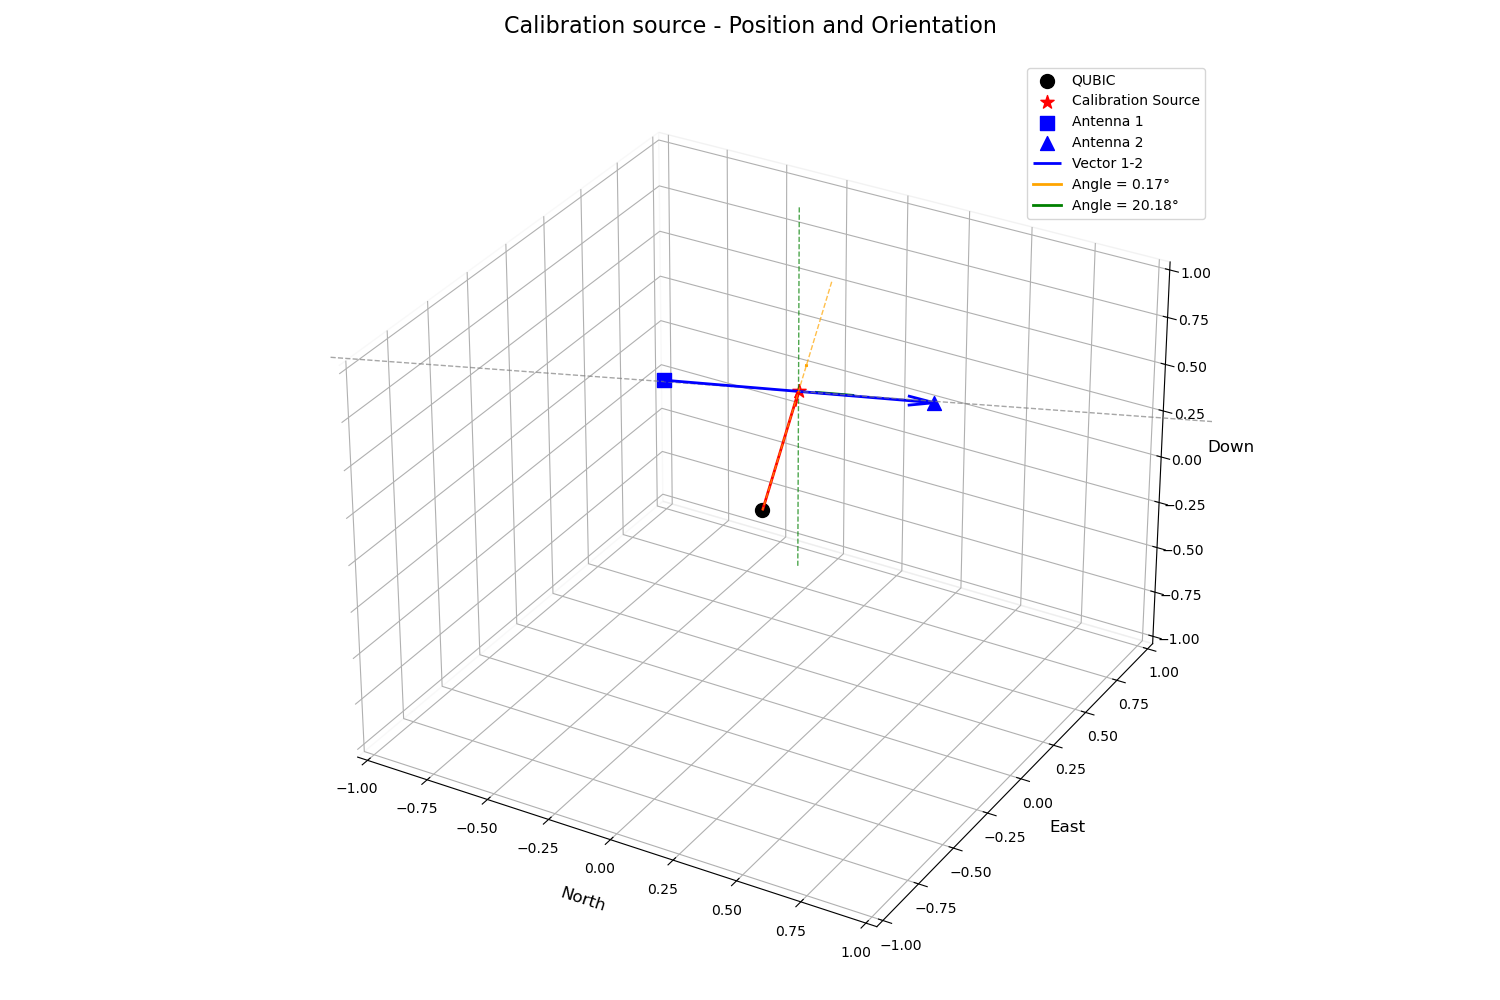

In [10]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(gps.base_antenna_position[0], gps.base_antenna_position[1], gps.base_antenna_position[2], color='k', s=100, label='QUBIC')
ax.scatter(gps.vector_calsource_xyz[0, idx], gps.vector_calsource_xyz[1, idx], gps.vector_calsource_xyz[2, idx], color='r', marker='*', s=100, label='Calibration Source')

ax.quiver(gps.base_antenna_position[0], gps.base_antenna_position[1], gps.base_antenna_position[2], 
            gps.vector_calsource_xyz[0, idx] - gps.base_antenna_position[0], 
            gps.vector_calsource_xyz[1, idx] - gps.base_antenna_position[1], 
            gps.vector_calsource_xyz[2, idx] - gps.base_antenna_position[2], 
            color='r', arrow_length_ratio=0.1, linewidth=2)
ax.quiver(gps.base_antenna_position[0], gps.base_antenna_position[1], gps.base_antenna_position[2], 
            (gps.vector_calsource_xyz[0, idx] - gps.base_antenna_position[0])*2, 
            (gps.vector_calsource_xyz[1, idx] - gps.base_antenna_position[1])*2, 
            (gps.vector_calsource_xyz[2, idx] - gps.base_antenna_position[2])*2, 
            color='orange', arrow_length_ratio=0., linewidth=1, linestyle='--', alpha=0.7)

orth = np.cross(gps.vector_calsource_xyz[:, idx][:, 0], np.array([0, 0, 1]))
print(orth)
ax.quiver(gps.vector_calsource_xyz[0,idx], gps.vector_calsource_xyz[1,idx], gps.vector_calsource_xyz[2, idx], 
            (orth[0] - gps.base_antenna_position[0])*2, 
            (orth[1] - gps.base_antenna_position[1])*2, 
            (orth[2] - gps.base_antenna_position[2])*2, 
            color='grey', arrow_length_ratio=0., linewidth=1, linestyle='--', alpha=0.7)
ax.quiver(gps.vector_calsource_xyz[0,idx], gps.vector_calsource_xyz[1,idx], gps.vector_calsource_xyz[2, idx], 
            (orth[0] - gps.base_antenna_position[0])*-2, 
            (orth[1] - gps.base_antenna_position[1])*-2, 
            (orth[2] - gps.base_antenna_position[2])*-2, 
            color='grey', arrow_length_ratio=0., linewidth=1, linestyle='--', alpha=0.7)
ax.quiver(gps.vector_calsource_xyz[0,idx], gps.vector_calsource_xyz[1,idx], gps.vector_calsource_xyz[2, idx] - 1, 
            0, 
            0, 
            2, 
            color='green', arrow_length_ratio=0., linewidth=1, linestyle='--', alpha=0.7)

ax.scatter(gps.position_antenna1_xyz[0, idx], gps.position_antenna1_xyz[1, idx], gps.position_antenna1_xyz[2, idx], color='b', marker='s', s=100, label='Antenna 1')
ax.scatter(gps.position_antenna2_xyz[0, idx], gps.position_antenna2_xyz[1, idx], gps.position_antenna2_xyz[2, idx], color='b', marker='^', s=100, label='Antenna 2')
ax.quiver(gps.position_antenna1_xyz[0, idx], gps.position_antenna1_xyz[1, idx], gps.position_antenna1_xyz[2, idx], 
            gps.position_antenna2_xyz[0, idx] - gps.position_antenna1_xyz[0, idx], 
            gps.position_antenna2_xyz[1, idx] - gps.position_antenna1_xyz[1, idx], 
            gps.position_antenna2_xyz[2, idx] - gps.position_antenna1_xyz[2, idx],
            color='b', arrow_length_ratio=0.1, linewidth=2, label='Vector 1-2')

plot_angle_arc(ax, gps.vector_calsource_xyz[:, idx][:, 0], gps.vector_calsource_xyz[:, idx][:, 0] - gps.base_antenna_position,
               (gps.position_antenna2_xyz[:, idx][:, 0] - gps.position_antenna1_xyz[:, idx][:, 0]), np.radians(gps.calsource_orientation_angles[0, idx][0]), radius=0.2, color='orange')
# ax.text(gps.vector_calsource_xyz[0,0] - 0.2, gps.vector_calsource_xyz[1,0], gps.vector_calsource_xyz[2, 0], f'{gps.calsource_orientation_angles[0, 0]:.2f} °',
#         color='orange', fontsize=12, ha='left', va='center')
plot_angle_arc(ax, gps.vector_calsource_xyz[:, idx][:, 0], 
               orth,
               gps.position_antenna1_xyz[:, idx][:, 0] - gps.position_antenna2_xyz[:, idx][:, 0], np.radians(gps.calsource_orientation_angles[2, idx][0]), radius=0.2, color='green')
# ax.text(gps.vector_calsource_xyz[0,0] + 0.2, gps.vector_calsource_xyz[1,0], gps.vector_calsource_xyz[2, 0], f'{gps.calsource_orientation_angles[2, 0]:.2f} °',
#         color='green', fontsize=12, ha='right', va='center')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('North', fontsize=12, labelpad=10)
ax.set_ylabel('East', fontsize=12, labelpad=10)
ax.set_zlabel('Down', fontsize=12, labelpad=10)

ax.set_title('Calibration source - Position and Orientation', fontsize=16, pad=20)
ax.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.legend()
plt.tight_layout()